Distance au défaut (dd) : 1.838410
Probabilité de défaut (PD) : 0.033001
Moyenne des proportions de pertes simulées : 0.033043


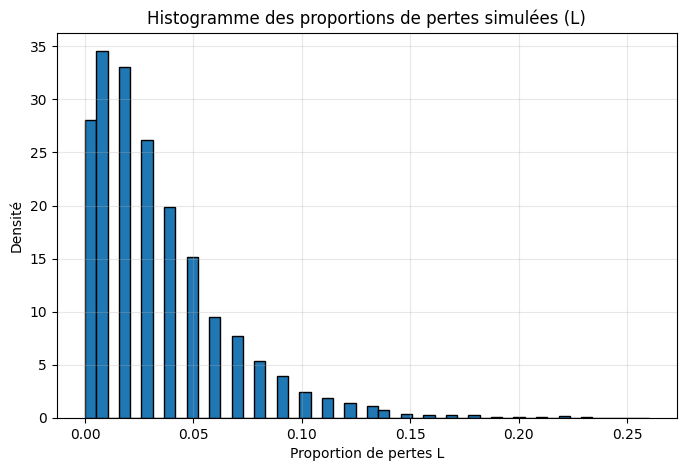

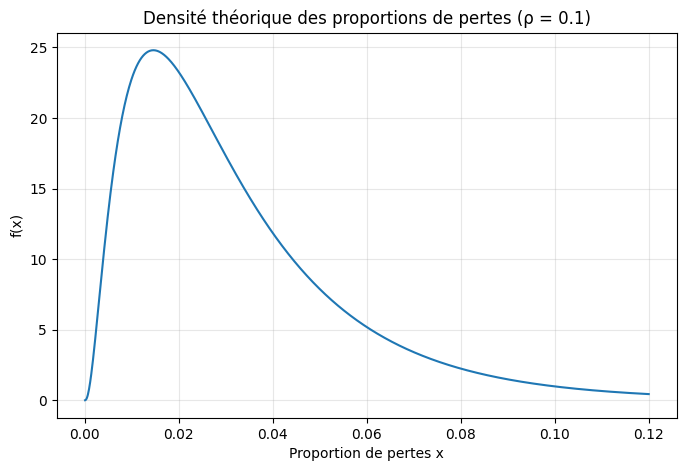

Pr(L < 0.0823) (analytique) : 0.949939
Pr(L < 0.0823) (simulation) : 0.932800
VaR analytique pour p = 5.0% : 0.082330
VaR simulée (centile 95.0%) : 0.090000


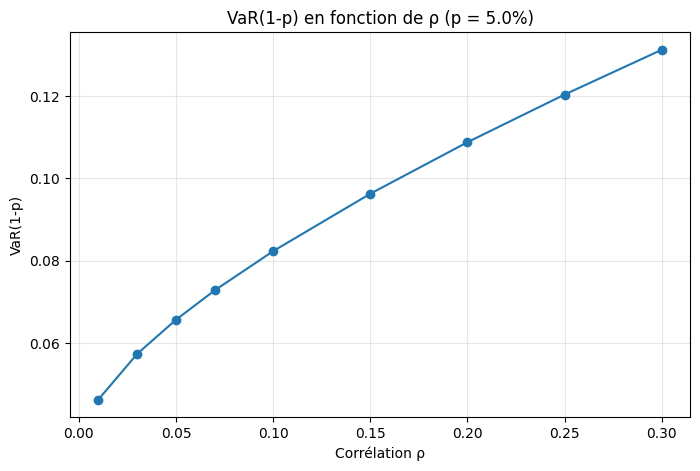

In [3]:
# ============================================================
# Travail pratique - Modèle de Vasicek (2002)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

 
# Partie 1 : Définition des paramètres du modèle


A0 = 100     # Valeur initiale des actifs
alpha = 0.1  # Paramètre alpha 
sigma = 0.2  # Volatilité
B_bar = 75   # Seuil de défaut B
T = 1        # Horizon (en années)
rho = 0.1    # Corrélation (paramètre ρ du modèle)
n = 100      # Nombre de firmes dans le portefeuille


# Partie 2 : Distance au défaut et probabilité de défaut PD

# Formule de la distance au défaut (dd)
# PD = Pr(ln A_T < ln B) = N(-dd)
# dd = [ln(A0/B) + (alpha - 0.5*sigma^2)*T] / (sigma*sqrt(T))

dd = (np.log(A0 / B_bar) + (alpha - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
PD = norm.cdf(-dd)

print(f"Distance au défaut (dd) : {dd:.6f}")
print(f"Probabilité de défaut (PD) : {PD:.6f}")


# Partie 3 : Simulation de 10 000 trajectoires de L

# Procédure de simulation (pour chaque trajectoire) :
# 1. Simuler F ~ N(0,1)
# 2. Simuler n valeurs e_i ~ N(0,1)
# 3. z_i = sqrt(rho)*F + sqrt(1-rho)*e_i
# 4. ln(A_i,T) = ln(A0) + (alpha - 0.5*sigma^2)*T + sigma*sqrt(T)*z_i
# 5. défaut si ln(A_i,T) < ln(B_bar)  => perte L_i = 1, sinon 0
# 6. L = (1/n) * somme_i L_i

m = 10_000  # nombre de trajectoires simulées

# Vecteur pour stocker les proportions de pertes simulées (L)
L_sim = np.zeros(m)

for k in range(m):
    # Facteur commun
    F = np.random.normal(0.0, 1.0)
    # Chocs idiosyncratiques
    e = np.random.normal(0.0, 1.0, n)
    # z_i
    z = np.sqrt(rho) * F + np.sqrt(1.0 - rho) * e
    # ln(A_i,T)
    A_T = A0 * np.exp((alpha - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    # Indicateurs de défaut
    defaults = (A_T < (B_bar)).astype(int)
    # Proportion de défauts dans le portefeuille
    L_sim[k] = defaults.mean()

# Moyenne des valeurs simulées (doit être proche de PD)
mean_L_sim = L_sim.mean()
print(f"Moyenne des proportions de pertes simulées : {mean_L_sim:.6f}")

# Histogramme des L simulés
plt.figure(figsize=(8, 5))
plt.hist(L_sim, bins=50, density=True, edgecolor='black')
plt.title("Histogramme des proportions de pertes simulées (L)")
plt.xlabel("Proportion de pertes L")
plt.ylabel("Densité")
plt.grid(True, alpha=0.3)
plt.show()


# Partie 4 : Fonction de densité des proportions de pertes


def vasicek_pdf(x, PD, rho):

    x = np.asarray(x)
    # x doit être entre 0 et 1
    eps = 1e-12
    x = np.clip(x, eps, 1 - eps)

    z = norm.ppf(x)
    z_PD = norm.ppf(PD)

    coef = np.sqrt((1 - rho) / rho)
    exponent = (-(1 / (2 * rho))) * (np.sqrt(1.0 - rho) * z - z_PD)**2 + 0.5 *( z**2)

    return coef * np.exp(exponent)

# Reproduction du graphique de la densité pour rho = 0.1
x_grid = np.linspace(0.0001, 0.12, 1000)
pdf_vals = vasicek_pdf(x_grid, PD, rho)

plt.figure(figsize=(8, 5))
plt.plot(x_grid, pdf_vals)
plt.title("Densité théorique des proportions de pertes (ρ = 0.1)")
plt.xlabel("Proportion de pertes x")
plt.ylabel("f(x)")
plt.grid(True, alpha=0.3)
plt.show()


# Partie 5 : Fonction de densité cumulative et Pr(L < x)


# Pr(L < x) = F(x; PD, rho) = N( ( sqrt(1-rho)*N^{-1}(x) - N^{-1}(PD) ) / sqrt(rho) )

def vasicek_cdf(x, PD, rho):
    
    x = np.asarray(x)
    eps = 1e-12
    x = np.clip(x, eps, 1 - eps)

    z = norm.ppf(x)
    z_PD = norm.ppf(PD)

    arg = (np.sqrt(1.0 - rho) * z - z_PD) / np.sqrt(rho)
    return norm.cdf(arg)

# Calcul analytique de Pr(L < 0.0823)
x_star = 0.0823
prob_analytic = vasicek_cdf(x_star, PD, rho)
print(f"Pr(L < {x_star}) (analytique) : {prob_analytic:.6f}")

# Estimation par simulation à partir de L_sim
prob_sim = np.mean(L_sim < x_star)
print(f"Pr(L < {x_star}) (simulation) : {prob_sim:.6f}")

# ------------------------------------------------------------
# Partie 6 : Fonction VaR et calcul pour p = 5%
# ------------------------------------------------------------
# Formule (3) des diapositives :
# VaR(1-p) = N( ( sqrt(rho)*N^{-1}(1-p) + N^{-1}(PD) ) / sqrt(1-rho) )

def vasicek_var(PD, rho, p):
    """
    VaR(1-p) pour le modèle de Vasicek.
    p est la probabilité dans la "queue" droite (par ex. p = 0.05 pour VaR à 95%).
    """
    z_PD = norm.ppf(PD)
    z_tail = norm.ppf(1.0 - p)  # quantile 1-p
    arg = (np.sqrt(rho) * z_tail + z_PD) / np.sqrt(1.0 - rho)
    return norm.cdf(arg)

p = 0.05
var_analytic = vasicek_var(PD, rho, p)
print(f"VaR analytique pour p = {p*100:.1f}% : {var_analytic:.6f}")

# VaR estimée à partir des trajectoires de L (centile 1-p = 95%)
var_sim = np.percentile(L_sim, 100 * (1.0 - p))
print(f"VaR simulée (centile {100*(1-p):.1f}%) : {var_sim:.6f}")

# ------------------------------------------------------------
# Partie 7 : VaR en fonction de ρ
# ------------------------------------------------------------
# On peut reprendre la feuille Excel "Var_et_rho" en faisant varier ρ.

rho_values = np.array([0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3])
var_rho = np.array([vasicek_var(PD, r, p) for r in rho_values])

plt.figure(figsize=(8, 5))
plt.plot(rho_values, var_rho, marker='o')
plt.title(f"VaR(1-p) en fonction de ρ (p = {p*100:.1f}%)")
plt.xlabel("Corrélation ρ")
plt.ylabel("VaR(1-p)")
plt.grid(True, alpha=0.3)
plt.show()
